In [1]:
# inline plotting instead of popping out
%matplotlib inline

import os
from IPython.display import display

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## **Decision Tree**

### **Preparing data**

In [2]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine//wine.data', header=None)

df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

display(df.head())

X = df.drop(labels='Class label', axis=1)
y = df['Class label']
#X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels:', np.unique(y))

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Training data points: 124
# Testing data points: 54
Class labels: [1 2 3]


### **Training**

In [3]:
# criterion : impurity function
# max_depth : maximum depth of tree
# random_state : seed of random number generator
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

### **Testing**

In [4]:
y_pred = tree.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy (tree): %.2f' % ((y_test == y_pred).sum() / y_test.shape[0]))

# a more convenient way to evaluate a trained model is to use the sklearn.metrics 
from sklearn.metrics import accuracy_score
print('Accuracy (tree, sklearn): %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 2
Accuracy (tree): 0.96
Accuracy (tree, sklearn): 0.96


### **Visualization**

Decision trees are an attractive model if we care about the interpretability of a model. By visualizing a tree, we can understand how a prediction is made by breaking down a classification rule into a series of questions about the data features.

A nice feature of the `DecisionTreeClassifier` in Scikit-learn is that it allows us to export the decision tree as a `.dot` file after training, which we can visualize using the [GraphViz](http://www.graphviz.org/) program. This program is freely available on Linux, Windows, and Mac OS X. For exmaple, if you have [Anaconda](https://www.anaconda.com/download/) installed, you can get GraphViz by simply executing the following command in command line:

```
    > conda install graphviz
```

After installing GraphViz, we can create the `tree.dot` file:

In [5]:
if not os.path.exists("./output/") : os.mkdir("./output/")
export_graphviz(
    tree,
    out_file='./output/tree.dot', 
    feature_names=X.columns.values
)

and then convert the `tree.dot` file into a PNG file by executing the following GraphViz command from the command line under the same directory where `tree.dot` resides:
```
    > dot -Tpng tree.dot -o fig-tree.png
```

## **Random Forests**

### **Training**

In [6]:
# criterion : impurity function
# n_estimators :  number of decision trees
# random_state : seed used by the random number generator
# n_jobs : number of cores for parallelism
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy (forest): %.2f' % accuracy_score(y_test, y_pred))

Accuracy (forest): 0.98


### **Computing Feature Importance**

 1) Flavanoids                     0.188736
 2) OD280/OD315 of diluted wines   0.162445
 3) Proline                        0.158390
 4) Color intensity                0.154620
 5) Alcohol                        0.102004
 6) Hue                            0.065470
 7) Total phenols                  0.049602
 8) Alcalinity of ash              0.030379
 9) Proanthocyanins                0.023283
10) Malic acid                     0.022439
11) Magnesium                      0.018800
12) Nonflavanoid phenols           0.012507
13) Ash                            0.011325


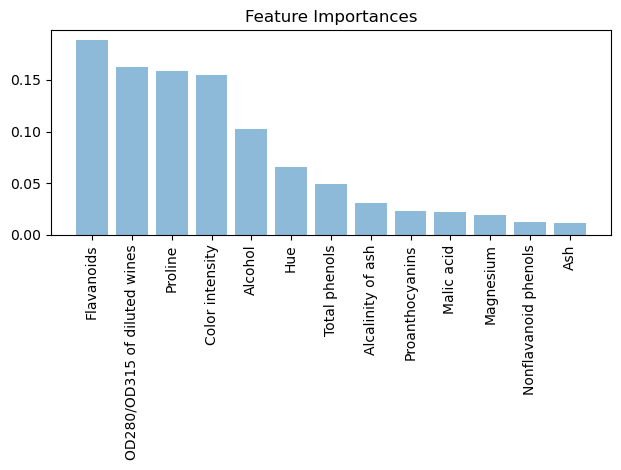

In [7]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.tight_layout()
plt.savefig('./output/fig-forest-feature-importances.png', dpi=300)
plt.show()


### **Feature Selection**

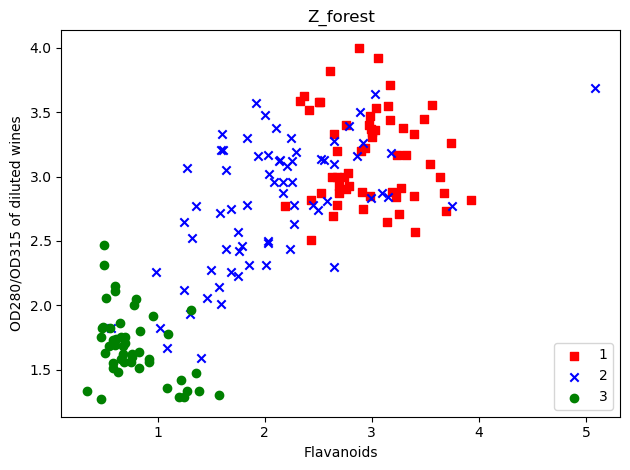

In [8]:
Z_forest = X[['Flavanoids', 'OD280/OD315 of diluted wines']].values

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y.values), colors, markers):
    plt.scatter(Z_forest[y.values==l, 0], 
                Z_forest[y.values==l, 1], 
                c=c, label=l, marker=m)

plt.title('Z_forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-forest-z.png', dpi=300)
plt.show()

In [9]:
# put prefitted RandomForestClassifier "forest" into SelectFromModel
sfm = SelectFromModel(forest, threshold=0.16, prefit=True)
Z_forest_alt = sfm.transform(X.values)

for f in range(Z_forest_alt.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

 1) Flavanoids                     0.188736
 2) OD280/OD315 of diluted wines   0.162445


### **Dimension Reduction: PCA vs. Random Forest**

In [11]:
# train a decision tree based on Z_forest

Z_forest_train, Z_forest_test, y_forest_train, y_forest_test = train_test_split(
    Z_forest, y, test_size=0.3, random_state=0)

tree_forest = DecisionTreeClassifier(criterion='entropy', 
                                     max_depth=3, 
                                     random_state=0)
tree_forest.fit(Z_forest_train, y_forest_train)

y_forest_pred = tree_forest.predict(Z_forest_test)
print('Accuracy (tree_forest): %.2f' % accuracy_score(y_forest_test, y_forest_pred))

# train a decision tree based on Z_pca

# load Z_pca that we have created in our last lab
Z_pca= np.load('./output/Z_pca.npy')
# random_state should be the same as that used to split the Z_forest
Z_pca_train, Z_pca_test, y_pca_train, y_pca_test = train_test_split(
    Z_pca, y, test_size=0.3, random_state=0)

tree_pca = DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=3, 
                                  random_state=0)
tree_pca.fit(Z_pca_train, y_pca_train)

y_pca_pred = tree_pca.predict(Z_pca_test)
print('Accuracy (tree_pca): %.2f' % accuracy_score(y_pca_test, y_pca_pred))

Accuracy (tree_forest): 0.83
Accuracy (tree_pca): 0.96


In [12]:
# train a random forest based on Z_forest

forest_forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest_forest.fit(Z_forest_train, y_forest_train)

y_forest_pred = forest_forest.predict(Z_forest_test)
print('Accuracy (forest_forest): %.2f' % accuracy_score(y_forest_test, y_forest_pred))


# train a random forest based on Z_pca

forest_pca = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest_pca.fit(Z_pca_train, y_pca_train)

y_pca_pred = forest_pca.predict(Z_pca_test)
print('Accuracy (forest_pca): %.2f' % accuracy_score(y_pca_test, y_pca_pred))

Accuracy (forest_forest): 0.67
Accuracy (forest_pca): 0.98


### **Further Visualization**

In [13]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)], # Prevents warning
            marker = markers[idx],
            label = cl
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c=[cmap(i - 1) for i in y_test],
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')

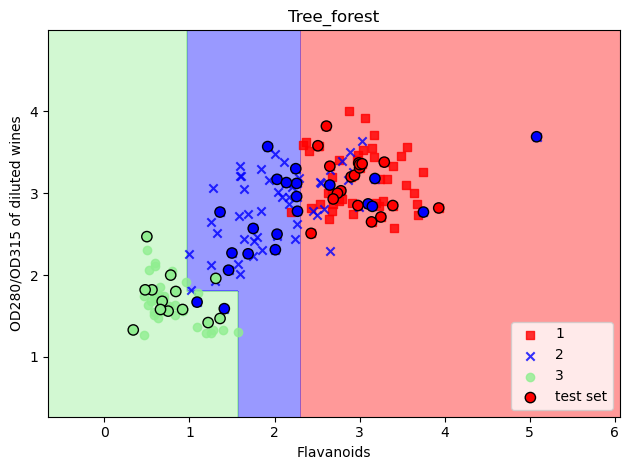

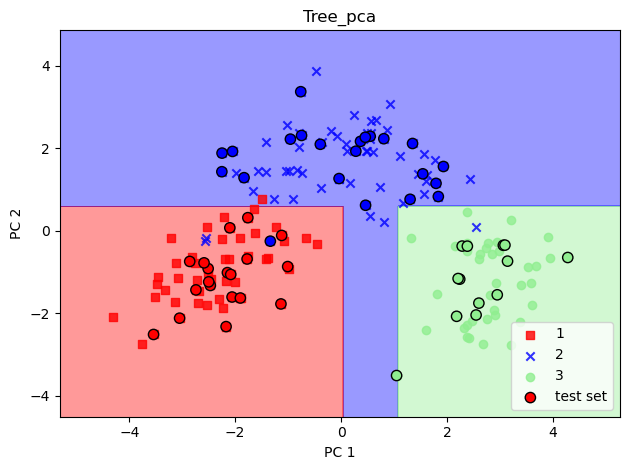

In [14]:
# plot boundaries of tree_forest
Z_forest_combined = np.vstack((Z_forest_train, Z_forest_test))
y_forest_combined = np.hstack((y_forest_train, y_forest_test))
plot_decision_regions(
        Z_forest_combined, 
        y_forest_combined, 
        classifier = tree_forest, 
        test_idx = range(
            y_forest_train.shape[0],
            y_forest_train.shape[0] + y_forest_test.shape[0]
        )
)

plt.title('Tree_forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-tree-forest.png', dpi=300)
plt.show()

# plot boundaries of tree_pca
Z_pca_combined = np.vstack((Z_pca_train, Z_pca_test))
y_pca_combined = np.hstack((y_pca_train, y_pca_test))
plot_decision_regions(
    Z_pca_combined, 
    y_pca_combined, 
    classifier = tree_pca, 
    test_idx = range(
        y_pca_train.shape[0],
        y_pca_train.shape[0] + y_pca_test.shape[0]
    )
)

plt.title('Tree_pca')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-tree-pca.png', dpi = 300)
plt.show()


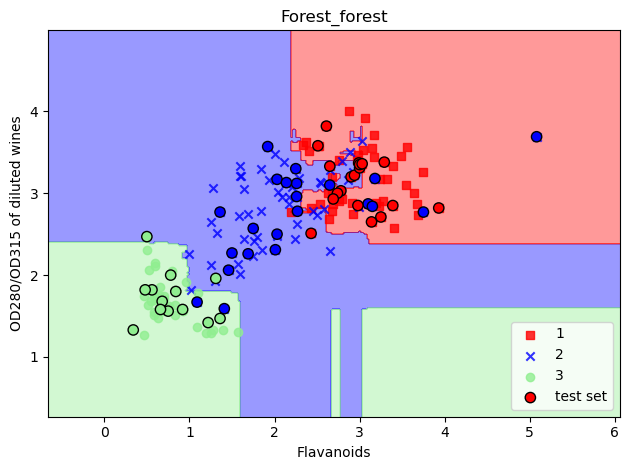

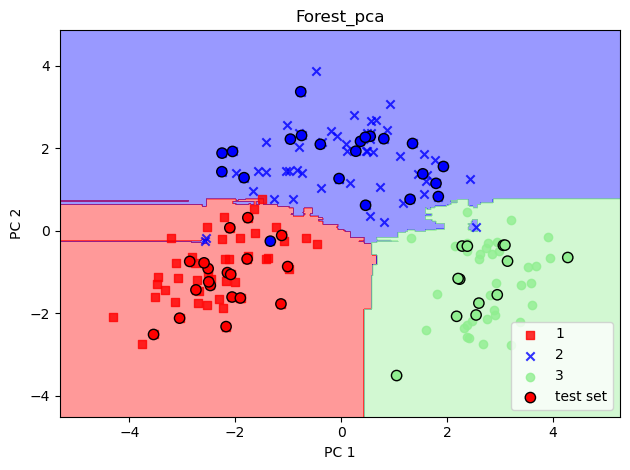

In [15]:
# plot boundaries of tree_forest
plot_decision_regions(Z_forest_combined, 
                      y_forest_combined, 
                      classifier=forest_forest, 
                      test_idx=range(y_forest_train.shape[0],
                                     y_forest_train.shape[0] + y_forest_test.shape[0]))

plt.title('Forest_forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-forest-forest.png', dpi=300)
plt.show()

# plot boundaries of tree_pca
plot_decision_regions(Z_pca_combined, 
                      y_pca_combined, 
                      classifier=forest_pca, 
                      test_idx=range(y_pca_train.shape[0],
                                     y_pca_train.shape[0] + y_pca_test.shape[0]))

plt.title('Forest_pca')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-forest-pca.png', dpi=300)
plt.show()